## The New York Times Covid-19 Database

The New York Times Covid-19 Database is 
a county-level database of confirmed cases and deaths, 
compiled from state and local governments and health departments across the United States.
The initial release of the database was on Thursday, March 26, 2020, and it is updated daily. 

These data have fueled many articles and graphics by The Times; these are updated regularly at
[https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html). 
The Times has created many visualizations that are effective communications of important information about the pandemic. 

The data are publically available via GitHub: [https://github.com/nytimes/covid-19-data](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html).  In this illustration we will only use
the data aggregated at the state level. 

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
covid_table = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv")
covid_table = covid_table.drop('fips', axis=1)
covid_table.tail(20)

,date,state,cases,deaths
50554,2022-09-01,North Dakota,264750,2395
50555,2022-09-01,Northern Mariana Islands,13120,40
50556,2022-09-01,Ohio,3074826,39490
50557,2022-09-01,Oklahoma,1174015,14744
50558,2022-09-01,Oregon,878610,8415
50559,2022-09-01,Pennsylvania,3185902,46716
50560,2022-09-01,Puerto Rico,959930,4979
50561,2022-09-01,Rhode Island,418635,3645
50562,2022-09-01,South Carolina,1674281,18263
50563,2022-09-01,South Dakota,257547,2993


### Process the recent data

Here is some code that creates a Table with the recent Covid-19 statistics for a given state. Just pass in the name of the state as a string.


In [3]:
merged_data = covid_table.drop('state', axis=1)
merged_data = merged_data.groupby('date').sum()
merged_data.tail(20)

,cases,deaths
date,,
2022-08-13,92654539,1033195
2022-08-14,92665243,1033207
2022-08-15,92794605,1033762
2022-08-16,92915222,1034234
2022-08-17,93075325,1035194
2022-08-18,93201691,1035802
2022-08-19,93310182,1036333
2022-08-20,93318109,1036360
2022-08-21,93326631,1036368


In [4]:
new_cases = np.diff(merged_data['cases'])

# compute 7-day average
avg_cases = np.zeros(7)
for i in np.arange(7, len(new_cases)):
    avg_cases = np.append(avg_cases, np.mean(new_cases[(i-6):i+1]))

dates = np.array(merged_data['cases'].index)[1:]
data = np.array([new_cases, avg_cases]).T
cvd19 = pd.DataFrame(data, columns = ['new cases', '7-day avg'], index=dates)
cvd19.tail(10)

,new cases,7-day avg
2022-08-23,105203.0,91036.285714
2022-08-24,174362.0,93073.285714
2022-08-25,111177.0,90903.428571
2022-08-26,102432.0,90037.857143
2022-08-27,8823.0,90165.857143
2022-08-28,8539.0,90168.285714
2022-08-29,112305.0,88977.285714
2022-08-30,117036.0,90667.714286
2022-08-31,154590.0,87843.142857
2022-09-01,108660.0,87483.571429


In [5]:
cvd19.describe()

,new cases,7-day avg
count,9.540000e+02,954.000000
mean,9.900461e+04,98666.802636
std,1.379256e+05,122173.910913
min,-2.399900e+04,0.000000
25%,2.709350e+04,32345.321429
50%,5.761300e+04,66529.142857
75%,1.294662e+05,117947.678571
max,1.433977e+06,806927.857143


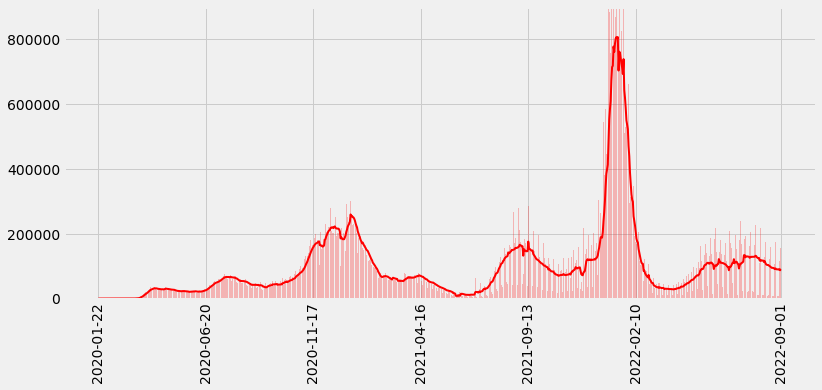

In [6]:
plt.figure(figsize=(12,5))
plt.bar(cvd19.index, cvd19['new cases'], color='red', alpha=.25)
plt.plot(cvd19.index, cvd19['7-day avg'], color='red', linewidth=2)
plt.xlabel('')
_ = plt.xticks(cvd19.index[list(np.arange(0, 900, 150)) + [len(dates)-1]], rotation=90)
_ = plt.yticks(np.arange(0, 850000, 200000))
_ = plt.ylim(0, 900000)

Compare this to the graph here: [https://github.com/nytimes/covid-19-data](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html).


Let's now fit a linear regression to the recent data. First we filter to take everything after June 15.


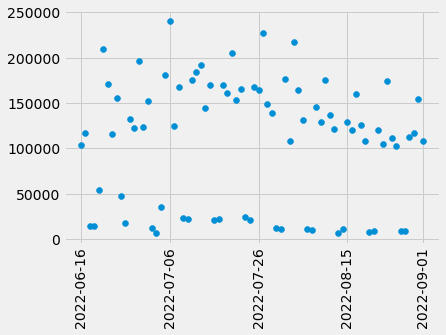

In [7]:
recent = cvd19[(cvd19.index > '2022-06-15') & (cvd19.index < '2022-09-09')]
y = recent['new cases']
dates = recent.index
plt.scatter(dates, y)
_ = plt.xticks(dates[[0, 20, 40, 60, len(dates)-1]], rotation=90)

Next we fit the "Ordinary Least Squares" regression using the `statsmodels.api` package.

In [8]:
import statsmodels.api as sm
x = np.arange(len(y))
X = sm.add_constant(x)
model = sm.OLS(y,X)
result = model.fit()
beta = [result.params.const, result.params.x1]

/Users/lafferty/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/lafferty/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


Finally, plot the results

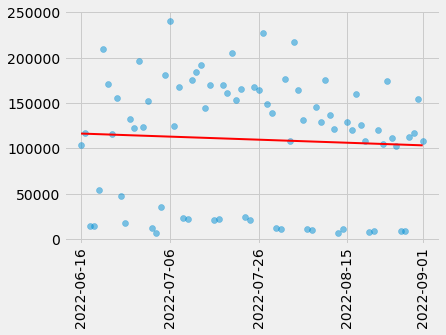

In [9]:
plt.scatter(dates, y, alpha=.5)
_ = plt.xticks(dates[[0, 20, 40, 60, len(dates)-1]], rotation=90)
_ = plt.plot(x, beta[0] + beta[1]*x, color='red', linewidth=2)

How would you describe the fit to the data? Can you filter out the low points (weekends?) and refit the model?